# Training length test for ARIMAX

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
import matplotlib.pyplot as plt
from pmdarima.model_selection import SlidingWindowForecastCV, cross_validate

label = pd.read_pickle('label.pkl')
features = pd.read_pickle('2021_features.pkl')

In [2]:
def FeatureSelection(features, label, alpha):
    # 1.layer
    impute(features);
    features_filtered = select_features(features, label)
    # 2.layer
    model = linear_model.Lasso(alpha=alpha)
    # standardization
    X = StandardScaler().fit_transform(np.array(features_filtered))
    y = np.array(label)
    model.fit(X, y)
    feature_coeff = pd.Series(model.coef_, index=features_filtered.columns)
    feature_coeff = feature_coeff.sort_values(ascending=False)
    feature_names = feature_coeff[feature_coeff.abs()>0].index
    selected_features = feature_coeff[feature_coeff.abs()>0]
    return feature_names, selected_features

def ARIMACV(label, features, alpha):
    n_fold = 5
    train_length = 24*7*4*2
    test_length = 24
    # get label
    train_label = pd.Series(label[-train_length-test_length:-test_length].value)
    test_label = pd.Series(label[-test_length:].value)
    # get feature matrix
    train_features = features[-train_length-test_length:-test_length]
    test_features = features[-test_length:]
    # get train/test X
    relevant_feature_names, _ = FeatureSelection(train_features, train_label, alpha)
    train_X = StandardScaler().fit_transform(np.array(train_features[relevant_feature_names]))
    test_X = StandardScaler().fit_transform(np.array(test_features[relevant_feature_names]))
    # train ARIMAX
    model = auto_arima(train_label, max_p=8, max_q=8, max_order=None, \
        seasonal=False, \
        exogenous=train_X, \
        trace=False, error_action="ignore", suppress_warnings=True, stepwise=True)
    # evaluation
    feature_length = len(relevant_feature_names)
    train_pred = model.predict_in_sample(train_X)
    train_smap = round(100 - smape(train_label, train_pred),1)
    test_pred = model.predict(n_periods=test_label.shape[0], X=test_X)
    test_smap = round(100 - smape(test_label, test_pred),1)
    # cross validation
    val_cutoff = -(train_length+test_length)*n_fold
    if -val_cutoff <= len(features):
        val_label = pd.Series(label[val_cutoff:].value)
        val_features = features[val_cutoff:]
        step = train_length+test_length
    else:
        val_label = pd.Series(label[-len(features):].value)
        val_features = features
        step = round((len(features)-(train_length+test_length))/n_fold)
    # get validation data
    val_features = val_features[relevant_feature_names]
    val_X = StandardScaler().fit_transform(np.array(val_features))
    # cross validation
    cv = SlidingWindowForecastCV(window_size=train_length, step=step, h=test_length)
    cv_result = cross_validate(model, val_label, val_X, scoring='smape', cv=cv)
    print(f'--------------------------------------')
    print(f'train_smap: {train_smap}%')
    print(f'test_smap: {test_smap}%')
    print(f'cv_mean: {round(100-cv_result["test_score"].mean(),1)}%')
    print(f'cv_std: {cv_result["test_score"].std()}')
    print(f'feature length: {feature_length}')
    return train_smap, test_smap, cv_result, feature_length

In [3]:
# feature selection
alphas = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 4, 8]
result = dict()
for alpha in alphas:
    train_smap, test_smap, cv_result, feature_length = ARIMACV(label, features, alpha)
    result[str(alpha)] = (train_smap, test_smap, cv_result, feature_length)

--------------------------------------
train_smap: 93.3%
test_smap: 72.0%
cv_mean: 91.5%
cv_std: 4.5937400424366155
feature length: 238
--------------------------------------
train_smap: 93.3%
test_smap: 72.0%
cv_mean: 90.2%
cv_std: 5.208490489414159
feature length: 165
--------------------------------------
train_smap: 93.0%
test_smap: 71.0%
cv_mean: 92.2%
cv_std: 4.761768735228416
feature length: 96
--------------------------------------
train_smap: 92.7%
test_smap: 70.6%
cv_mean: 90.3%
cv_std: 5.123294118187137
feature length: 75
--------------------------------------
train_smap: 92.6%
test_smap: 70.1%
cv_mean: 91.6%
cv_std: 4.281691233448288
feature length: 45
--------------------------------------
train_smap: 92.7%
test_smap: 70.4%
cv_mean: 91.5%
cv_std: 5.011672461128937
feature length: 37
--------------------------------------
train_smap: 92.7%
test_smap: 70.1%
cv_mean: 91.9%
cv_std: 4.370520972314398
feature length: 30
--------------------------------------
train_smap: 92.7%
te

In [4]:
np.save('lasso_coeff.npy', result) # np.load('my_file.npy',allow_pickle='TRUE').item()

In [12]:
print(round(100-result['0.01'][2]['test_score'].mean(),1))
print(result['0.01'][2]['test_score'].std())

90.2
5.208490489414159


In [18]:
train_cmap = []
test_cmap = []
cv_mean = []
low_bound = []
up_bound = []
fit_time = []
feature_len = []
for alpha in alphas:
    train_cmap.append(result[str(alpha)][0])
    test_cmap.append(result[str(alpha)][1])
    cv_value = round(100-result[str(alpha)][2]['test_score'].mean(),1)
    cv_mean.append(cv_value)
    low_bound.append(cv_value-result[str(alpha)][2]['test_score'].std())
    up_bound.append(cv_value+result[str(alpha)][2]['test_score'].std())
    fit_time.append(result[str(alpha)][2]['fit_time'].mean())
    feature_len.append(result[str(alpha)][3])

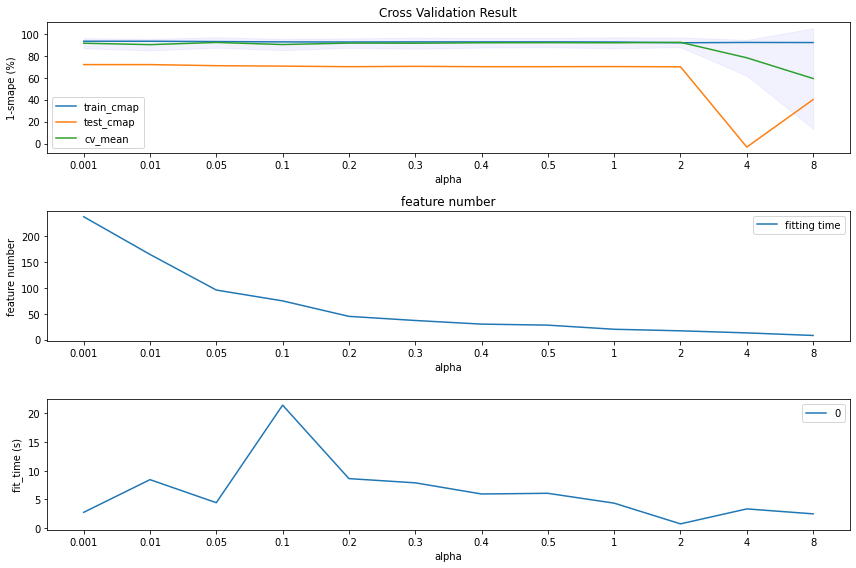

In [41]:
train_cmap = pd.DataFrame(train_cmap)
test_cmap = pd.DataFrame(test_cmap)
cv_mean = pd.DataFrame(cv_mean)
low_bound = np.array(low_bound)
up_bound = np.array(up_bound)
fit_time = pd.DataFrame(fit_time)
feature_len = pd.DataFrame(feature_len)
# plot
fig, ax = plt.subplots(3,1,figsize=(12,8))
train_cmap.plot(ax=ax[0])
test_cmap.plot(ax=ax[0])
cv_mean.plot(ax=ax[0])
ax[0].legend(['train_cmap','test_cmap','cv_mean'])
ax[0].set_xticks(np.arange(len(alphas)))
ax[0].set_xticklabels([str(x) for x in alphas])
ax[0].set_title(f'Cross Validation Result')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('1-smape (%)')
ax[0].fill_between(np.arange(0,len(low_bound)), low_bound, up_bound, \
                alpha=0.05, color='b')
feature_len.plot(ax=ax[1])
ax[1].set_title('feature number')
ax[1].set_ylabel('feature number')
ax[1].set_xticks(np.arange(len(alphas)))
ax[1].set_xlabel('alpha')
ax[1].set_xticklabels([str(x) for x in alphas])
ax[1].legend(['feature number'])
fit_time.plot(ax=ax[2])
ax[2].set_ylabel('fit_time (s)')
ax[2].set_xticks(np.arange(len(alphas)))
ax[2].set_xticklabels([str(x) for x in alphas])
ax[2].set_xlabel('alpha')
ax[1].legend(['fitting time'])
plt.tight_layout()

If we set alpha is equal to 2, than we get 92.28% cross validation accuracy with almost the same training accuracy. Lowest fitting time and minimal feature number.  